# Conditional VAE - Event probability estimator
The goal of this tutorial is to implement a CVAE in order to model the probability of a vehicle of having an accident given the information we know about it.
In other words, we want to model $P(y|X)$, where $y$ is the number of accidents and $X$ is the information available about a vehicle. 

### **Steps:**
#### Step 1: Setup (librairies, data)
#### Step 2: Defining the model
#### Step 3: Defining the training procedure
#### Step 4: Train the model
#### Step 5: Testing the model on unseen data



## **Step 1: Setup (librairies, data)**

### Add dependencies

In [0]:
!pip install torch
!pip install googledrivedownloader

### Loading librairies

In [0]:
import os
import time
import random
import math
import random
import numpy as np
import pandas as pd
import argparse
from itertools import chain
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
from torch.autograd import Variable
from torch import device as device_
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
from distutils.util import strtobool
from sklearn.preprocessing import StandardScaler
from random import sample

from datetime import datetime
import sys
import os
import pickle
from scipy.stats import nbinom
from google.colab import files
import io

from google_drive_downloader import GoogleDriveDownloader

### Uploading the data
The data has already been preprocessed and split into training, validation and test sets.

In [0]:
GoogleDriveDownloader.download_file_from_google_drive(file_id='1U986irw9-7FgVk35bQD3izhT4If0fWZx', dest_path='/data_train_.csv', unzip=False)
GoogleDriveDownloader.download_file_from_google_drive(file_id='1eLIITImFMu-BDMV2Iw7SrjdbVOh_Afnf', dest_path='/data_val_.csv', unzip=False)
GoogleDriveDownloader.download_file_from_google_drive(file_id='1JreaakeyJOSiRLqsOHGJUNC1alqXzo90', dest_path='/data_test_.csv', unzip=False)

In [0]:
# Using pandas, upload datasets to dataframes
data_train = pd.read_csv('/data_train_.csv')
data_val = pd.read_csv('/data_val_.csv')
data_test = pd.read_csv('/data_test_.csv')

# Separate X from X
y_train = data_train['y'].values
y_val = data_val['y'].values
y_test = data_test['y'].values

X_train = data_train.drop(['y'], axis=1).values
X_val = data_val.drop(['y'], axis=1).values
X_test = data_test.drop(['y'], axis=1).values

# convert X,y pairs to dataloaders (this is specific to pytorch)
train_loader = DataLoader(TensorDataset(
                        torch.tensor(X_train, dtype=torch.float),
                        torch.tensor(y_train, dtype=torch.float)),
                    batch_size=32, shuffle=True
                    )

val_loader = DataLoader(TensorDataset(
                torch.tensor(X_val, dtype=torch.float),
                torch.tensor(y_val, dtype=torch.float)),
            batch_size=X_val.shape[0], shuffle=True
            )

test_loader = DataLoader(TensorDataset(
                torch.tensor(X_test, dtype=torch.float),
                torch.tensor(y_test, dtype=torch.float)),
            batch_size=X_test.shape[0], shuffle=True
            )

print(data_train)

             x1        x2        x3        x4        x5  ...  x79  x80  x81  x82  y
0     -0.283897 -0.237801 -0.049301 -0.103192 -0.097451  ...    0    0    0    0  1
1     -0.283897 -0.237801 -0.049301 -0.103192 -0.097451  ...    1    0    0    0  0
2     -0.283897 -0.237801 -0.049301 -0.103192 -0.097451  ...    0    0    1    0  1
3     -0.283897 -0.237801 -0.049301 -0.103192 -0.097451  ...    0    0    0    0  0
4     -0.283897 -0.237801 -0.049301 -0.103192 -0.097451  ...    0    0    0    1  1
...         ...       ...       ...       ...       ...  ...  ...  ...  ...  ... ..
35926 -0.283897 -0.237801 -0.049301 -0.103192 -0.097451  ...    1    0    0    0  0
35927 -0.283897 -0.237801 -0.049301 -0.103192 -0.097451  ...    0    0    0    0  1
35928 -0.283897 -0.237801 -0.049301 -0.103192 -0.097451  ...    0    0    0    0  0
35929 -0.283897 -0.237801 -0.049301 -0.103192 -0.097451  ...    1    0    0    0  0
35930 -0.283897 -0.237801 -0.049301 -0.103192 -0.097451  ...    0    0    0 

## **Step 2: Defining the Model**
Piece by piece, we will define the components of a Negative Binomial Conditional VAE
- A Classifier
- An Encoder
- A Prior Encoder
- A Recognition Encoder
- A Decoder







### The Classifier 
The classifier's role is to provide an approximation of $y$. It maps $X$ to $y$ where in this cas $y$ was chosen to be a class. 

![alt text](https://drive.google.com/uc?id=1GBGLafjX_LsxT14p5obKhYrsqJ6Tf3E5)



In [0]:
class Classifier(nn.Module):
    def __init__(self, input_dim, n_neurons, dropout, output_dim):
        super(Classifier, self).__init__()

        self.n_neurons = n_neurons
        self.dropout = dropout
        self.input_dim = input_dim

        layers = []
        n_layers = len(n_neurons)

        # first layer
        layers.append(nn.Sequential(
            nn.Linear(input_dim, n_neurons[0]),
            nn.Tanh(),
            nn.Dropout(p=dropout),
            nn.BatchNorm1d(n_neurons[0]),
            )
        )

        # hidden layers
        for i in range(1, n_layers):
            layers.append(nn.Sequential(
            nn.Linear(n_neurons[i-1], n_neurons[i]),
            nn.Tanh(),
            nn.Dropout(p=dropout),
            nn.BatchNorm1d(n_neurons[i]),
            )
        )


        self.lin = nn.Linear(n_neurons[-1], output_dim)
        self.soft = nn.Softmax(dim=1)
        self.fcl = nn.Sequential(*layers)
        

    def forward(self, x):
        out = self.lin(self.fcl(x))
        return self.soft(out)
    

### The Encoder
Architecture for both the Prior Encoder and Recognition Encoder


In [0]:
class Encoder(nn.Module):
    def __init__(self, input_dim, latent_dim, n_neurons, dropout=0.):
        super(Encoder, self).__init__()

        n1 = n_neurons[0]
        n2 = n_neurons[1]

        self.encoder = nn.Sequential(
            nn.Linear(input_dim, n1),
            nn.Tanh(),
            nn.Dropout(p=dropout),
            nn.BatchNorm1d(n1),
            
            nn.Linear(n1, n2),
            nn.Tanh(),
            nn.Dropout(p=dropout),
            nn.BatchNorm1d(n2)
        )

        self.read_mu = nn.Linear(n2, latent_dim)
        self.read_logvar = nn.Linear(n2, latent_dim)

    def forward(self, y, X):
        inputs = torch.cat((y.unsqueeze(1).long(), X.long()), dim=1)
        out = self.encoder(inputs.float())
        mu = self.read_mu(out)
        logvar = self.read_logvar(out)
 
        return mu, logvar


### The Prior Encoder
Merging the Classifier and Encoder to model $p(z|X)$

![alt text](https://drive.google.com/uc?id=1Z9EG-CDJK0vfPoYo9nZdeGC4PjfO1XaU)

In [0]:
class PriorEncoder(nn.Module):
    def __init__(self, input_dim, latent_dim, n_neurons_mlp, n_neurons_e, dropout, output_dim):
        super(PriorEncoder, self).__init__()

        self.clf = Classifier(input_dim-1, n_neurons_mlp, dropout, output_dim)
        self.encoder = Encoder(input_dim, latent_dim, n_neurons_e, dropout)

    def parameters(self):
        return chain(self.clf.parameters(), self.encoder.parameters())

    def forward(self, X):
        y_prob = self.clf(X)
        y_pred = torch.max(y_prob, 1)[1]
        mu, logvar = self.encoder(y_pred, X)

        return mu, logvar


## The Recognition Encoder
To approximate $q(z|X,y)$, also serves as the support for training the Prior Encoder.

![alt text](https://drive.google.com/uc?id=18Vz2LFMrE-pZf1-SyRCB9jiI-Obha9Zs)

In [0]:
class RecognitionEncoder(nn.Module):
    def __init__(self, input_dim, latent_dim, n_neurons_e, dropout):
        super(RecognitionEncoder, self).__init__()

        self.encoder = Encoder(input_dim, latent_dim, n_neurons_e, dropout)

    # def parameters(self):
    #     return chain(self.encoder.parameters())

    def forward(self, y, X):
        mu, logvar = self.encoder(y, X)
        return mu, logvar


## The Decoder
Models $p(y|X,z)$

![alt text](https://drive.google.com/uc?id=1bFIvOAm6xp3ovbFUqR1DLFSKCv4rK4rJ)

In [0]:
class Decoder(nn.Module):
    def __init__(self, input_dim, output_dim, n_neurons, dropout):
        super(Decoder, self).__init__()

        n1 = n_neurons[0]
        n2 = n_neurons[1]

        self.decoder = nn.Sequential(
            nn.Linear(input_dim, n1),
            nn.Tanh(),
            nn.Dropout(p=dropout),
            nn.BatchNorm1d(n1),
            
            nn.Linear(n1, n2),
            nn.Tanh(),
            nn.Dropout(p=dropout),
            nn.BatchNorm1d(n2),

        )

        self.fp = nn.Linear(n2, output_dim)
        self.fr = nn.Linear(n2, output_dim)

    def forward(self, z, X):
        inputs = torch.cat((z, X), dim=1)
        out = self.decoder(inputs)
        r = torch.exp(self.fr(out))
        p = 1/(1 + torch.exp(-self.fp(out)))
        return r, p 


# Putting all the pieces togetether
Now that we've defined all the different components of the Network, we can put it all together.

In [0]:
class NBCVAE(nn.Module):

    def __init__(self, input_dim, latent_dim, n_neurons_e, n_neurons_d, n_neurons_mlp, dropout, output_dim):
        super(NBCVAE, self).__init__()

        self.prior = PriorEncoder(input_dim+1, latent_dim,  n_neurons_mlp,  n_neurons_e, dropout, output_dim)
        self.recognition = RecognitionEncoder(input_dim+1, latent_dim, n_neurons_e, dropout)
        self.decoder = Decoder(input_dim+latent_dim, 1, n_neurons_d, dropout)

        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.n_neurons_e = n_neurons_e
        self.n_neurons_d = n_neurons_d
        self.n_neurons_mlp = n_neurons_mlp
        self.dropout = dropout
        self.output_dim = output_dim


    def parameters(self):
        return chain(self.prior.parameters(), self.recognition.parameters(), self.decoder.parameters())


    def sample_z(self, mu, logvar):
        epsilon = torch.randn(mu.size())
        epsilon = Variable(epsilon, requires_grad=False).type(torch.FloatTensor)
        sigma = torch.exp(logvar / 2)
        return mu + sigma * epsilon


    def forward(self, y, X):

        prior_mu, prior_logvar = self.prior(X)
        recogn_mu, recogn_logvar = self.recognition(y, X)

        prior_z = self.sample_z(prior_mu, prior_logvar)
        recogn_z = self.sample_z(recogn_mu, recogn_logvar)

        prior_r, prior_p  = self.decoder(prior_z, X)
        recogn_r, recogn_p  = self.decoder(recogn_z, X)

        return recogn_r, recogn_p, prior_r, prior_p, recogn_mu, recogn_logvar, prior_mu, prior_logvar


    def save(self, model_path: str):
      
        checkpoint = {
            'model_state_dict': self.state_dict()
        }
        torch.save(checkpoint, model_path)

    def load(self, model_path: str):
    
        checkpoint = torch.load(model_path)
        self.load_state_dict(checkpoint['model_state_dict'])
        return self 

## **Step 3: Define the training procedure**

### Define the loss function
Because we are using a negative binomial to model our $y$ variable, we need to define the reconstruction loss accordingly. 


In [0]:
class NBLLLoss:
    def __init__(self):
        pass

    def logP(self, r, p, y):
        NB = torch.distributions.negative_binomial.NegativeBinomial(total_count=r.reshape(1, -1).squeeze(), 
                                                                    probs=p.reshape(1, -1).squeeze())
        return NB.log_prob(y.reshape(1, -1).squeeze())

    def NBLLoss(self, r, p, y):
        log_prob = self.logP(r, p, y)
        log_lik = torch.mean(log_prob)
            
        return -log_lik

    def __call__(self, r, p, y):
        return self.NBLLoss(r, p, y)

In [0]:
class Trainer:
    def __init__(self, model, optimizer, criterion, n_epochs, path):
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.path = path
        self.n_epochs = n_epochs


    def train_iteration(self, train_loader):
        self.model.train()
        
        for X, y in train_loader:

            self.optimizer.zero_grad()
            _,_, prior_r, prior_p, recogn_mu, recogn_logvar, prior_mu, prior_logvar = self.model(y, X)

            loss_recon = self.criterion(prior_r, prior_p, y)

            kl_div = torch.sum((torch.log(prior_logvar.exp()) - torch.log(recogn_logvar.exp())) + 
                    ((recogn_logvar.exp()**2 + (recogn_mu - prior_mu)**2)/ (2*prior_logvar.exp()**2))) - 0.5

            loss = loss_recon + kl_div
            loss.backward()

            self.optimizer.step()


    def train(self, train_loader, val_loader, print_every=1, stopping_rule=1):
        best_epoch = 0
        best_loss = 100000

        for epoch in range(self.n_epochs):

            self.train_iteration(train_loader)

            train_loss, train_loss_recon, train_kl_div  = self.evaluate(train_loader)
            valid_loss, valid_loss_recon, valid_kl_div   = self.evaluate(val_loader)

            if valid_loss < best_loss:
                try:
                    os.remove('model_nbcvae.pt')
                except FileNotFoundError:
                    pass
                best_loss = valid_loss
                best_epoch = epoch
                self.model.save('model_nbcvae.pt')
                
            if (epoch + 1) % print_every == 0:
                message1 = f'| Epoch: {epoch+1:03}   | Train Loss: {train_loss:.3f} | Train Recon. Loss: {train_loss_recon:.3f} | Train KL Div: {train_kl_div:.3f}'
                message2 = f'|                Valid Loss: {valid_loss:.3f} | Valid Recon. Loss : {valid_loss_recon:.3f} | Valid KL Div: {valid_kl_div:.3f}'
                divider = '------------------------------------------------------------------------'

                print(message1)
                print(message2)
                print(divider)

            if epoch - best_epoch > stopping_rule:
                return epoch


    def evaluate(self, iterator):
        self.model.eval()

        epoch_loss, epoch_loss_recon, epoch_kl_div = 0, 0, 0
        n_batch = 0 

        with torch.no_grad():
            for X, y in iterator:

                _,_, prior_r, prior_p, recogn_mu, recogn_logvar, prior_mu, prior_logvar = self.model(y, X)

                loss_recon = self.criterion(prior_r, prior_p, y)

                kl_div = torch.sum((torch.log(prior_logvar.exp()) - torch.log(recogn_logvar.exp())) +
                        ((recogn_logvar.exp()**2 + (recogn_mu - prior_mu)**2)/ (2*prior_logvar.exp()**2))) - 0.5

                loss = loss_recon + kl_div/X.shape[0]
                epoch_loss += loss
                epoch_loss_recon += loss_recon
                epoch_kl_div += kl_div/X.shape[0]
                n_batch += 1

        return 100*epoch_loss/n_batch, 100*epoch_loss_recon/n_batch, 100*epoch_kl_div/n_batch


## **Step 4: Train the model**

#### Training hyperparameters

In [0]:
latent_dim = 12
n_neurons_e = [100, 50]
n_neurons_d = [50, 100]
n_neurons_clf = [100,100]
dropout = 0.3
output_dim = 1
learning_rate = 0.000001
weight_decay = 0.01
n_epochs = 500
stopping_rule = 10
input_dim = X_train.shape[1]
betas=(0.93,0.99)

In [0]:
# instantiate Negative 
model = NBCVAE(
        input_dim=X_train.shape[1], 
        latent_dim=latent_dim, 
        n_neurons_e=n_neurons_e, 
        n_neurons_d=n_neurons_d, 
        n_neurons_mlp=n_neurons_clf,
        dropout=dropout,
        output_dim=len(np.unique(y_train))
        )



# Define an Optimizer
optimizer = optim.Adam(
        model.parameters(),
        lr=learning_rate,
        betas=betas,
        weight_decay=weight_decay
    )


# Instantiate the reconstruction loss (during training we compute the KL divergence term)
criterion = NBLLLoss()

# instantiate training procedure
trainer = Trainer(model=model,
                  optimizer=optimizer,
                  criterion=criterion,
                  n_epochs=n_epochs,
                  path=''
                 )


In [0]:
# train
trainer.train(train_loader, val_loader, stopping_rule=stopping_rule) 

NameError: ignored


## **Step 5: Testing the model on unseen data**
We can create a class that will compute the probabilities for the test set and aggregate them.


In [0]:
class Probabilities:
    def __init__(self, model, NBLLLoss):
        self.model = model
        self.NBLLLoss = NBLLLoss


    def __call__(self, X, y):
        
        proba = pd.DataFrame(np.zeros((y.shape[0], 4)))
        proba.columns = ['P(y=0|X)', 'P(y=1|X)', 'P(y=2|X)', 'P(y=3|X)']

        _, _, _ , _, _, _, prior_mu, prior_logvar = self.model(torch.Tensor(y), torch.Tensor(X))  

        # sample 100 times
        p0 = np.zeros((y.shape[0], 100))
        p1 = np.zeros((y.shape[0], 100))
        p2 = np.zeros((y.shape[0], 100))
        p3 = np.zeros((y.shape[0], 100))
        
        for j in range(100):
            
            z = self.model.sample_z(prior_mu, prior_logvar)
            prior_r, prior_p  = self.model.decoder(z, torch.Tensor(X))
            NB = torch.distributions.negative_binomial.NegativeBinomial(total_count=prior_r.reshape(1, -1).squeeze().detach(), 
                                                                        probs=prior_p.reshape(1, -1).squeeze().detach())

            p0[:,j] = NB.log_prob(torch.ones(y.shape[0]) * 0).exp().detach().numpy()
            p1[:,j] = NB.log_prob(torch.ones(y.shape[0]) * 1).exp().detach().numpy()
            p2[:,j] = NB.log_prob(torch.ones(y.shape[0]) * 2).exp().detach().numpy()
            p3[:,j] = NB.log_prob(torch.ones(y.shape[0]) * 3).exp().detach().numpy()

        proba['P(y='+str(0)+'|X)'] = p0.mean(axis=1)
        proba['P(y='+str(1)+'|X)'] = p1.mean(axis=1)
        proba['P(y='+str(2)+'|X)'] = p2.mean(axis=1)
        proba['P(y='+str(3)+'|X)'] = p3.mean(axis=1)

        proba['nb_accidents'] = y

        # summary
        summary = proba.groupby('nb_accidents').mean()

        return summary, proba



In [0]:
GoogleDriveDownloader.download_file_from_google_drive(file_id='1-jBD7wpWSfIgFEada_kdJFqzDHTyfncN', dest_path='/model_nbcvae.pt', unzip=False)

In [0]:
# Load the model 
model.load('/model_nbcvae.pt')

# instantiate the Probabilities class
proba = Probabilities(model, NBLLLoss)

# Get probabilities and summary
summary_test, proba_test = proba(X=X_test, y=y_test)
print(summary_test.iloc[:-1,:])

              P(y=0|X)  P(y=1|X)  P(y=2|X)  P(y=3|X)
nb_accidents                                        
0             0.880101  0.093410  0.019591  0.004899
1             0.853701  0.111196  0.025239  0.006753
2             0.845398  0.115078  0.027718  0.007877
3             0.848928  0.111399  0.027696  0.008039


In [0]:
# Let's isolate the probabilities of having 0 accidents
proba0 = proba_test['P(y=0|X)'].values
nb_accidents = proba_test['nb_accidents'].values

# let's convert the number of accidents into a binary variable
had_accident = np.ones(proba_test.shape[0])
had_accident[nb_accidents == 0] = 0

# Create a summary table with the probabilities of having 0 accidents and the binary accident variable
data_summary = pd.DataFrame({'proba': 1-proba0, 'had_accident': had_accident, 'nb_accidents': nb_accidents})

# sort the probabilities from highest to lowest
data_summary = data_summary.sort_values(by='proba', ascending=False).reset_index(drop=True)
print(data_summary)


         proba  had_accident  nb_accidents
0     0.571936           0.0             0
1     0.525143           0.0             0
2     0.519653           1.0             2
3     0.498163           0.0             0
4     0.492355           1.0             1
...        ...           ...           ...
7694  0.036111           0.0             0
7695  0.036070           0.0             0
7696  0.035873           0.0             0
7697  0.035570           0.0             0
7698  0.034338           0.0             0

[7699 rows x 3 columns]


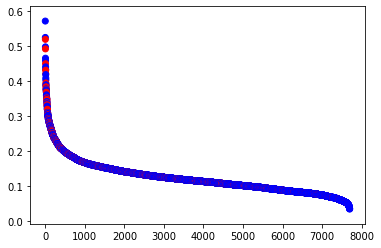

In [0]:
# plot the probabilities
LABEL_COLOR_MAP = {0 : 'b',
                   1 : 'r'
                   }


label_color = [LABEL_COLOR_MAP[l] for l in data_summary['had_accident'].values]

plt.scatter(np.arange(proba_test.shape[0]), data_summary['proba'].values, c=label_color)
plt.show()

In [0]:
# avg of top 100 and bottom 100 
top100 = data_summary.iloc[:100]
print('Avg probability of having 1 accident or more: ', 100*np.round(top100.mean(0)[0],2), '%')
print('Avg number of accidents: ', np.round(top100.mean(0)[1],2))
print('--------------------------------------------------------')
bottom100 = data_summary.iloc[-100:]
print('Avg probability of having 1+ accident: ', 100*np.round(bottom100.mean(0)[0],2), '%')
print('Avg number of accidents: ', np.round(bottom100.mean(0)[1],2))

Avg probability of having 1 accident or more:  34.0 %
Avg number of accidents:  0.34
--------------------------------------------------------
Avg probability of having 1+ accident:  5.0 %
Avg number of accidents:  0.03


### Conclusion:
